In [1]:
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

# Analysis

In [2]:
only_good_photos = True
pairplot = False
global output_path
output_path  = '/Users/danielfiuzadosil/Documents/GitHub_Repo/IPD_measuring_app/photos/output/plots/'

In [3]:
filepath = '/Users/danielfiuzadosil/Documents/GitHub_Repo/IPD_measuring_app/photos/output/photos_statistics_1259.csv'


In [4]:
df = pd.read_csv(filepath)

In [5]:
print(len(df))
df.columns

1259


Index(['filename', 'filepath', 'target', 'ipd_px', 'width_face_px',
       'height_face_px', 'top_to_bottom_angle', 'left_to_right_angle',
       'left_cheek_to_nose_angle', 'nose_to_right_cheek_angle',
       'area_px_left_silhoutte', 'area_px_right_silhoutte',
       'area_right_to_left_silhoutte', 'img_height', 'img_width'],
      dtype='object')

In [6]:
if only_good_photos == True:
    df = df[df['target'] == 'Good']

In [7]:
len(df)

1190

In [8]:
df['resolution_px'] = (df['img_height']*df['img_width'])
df['resolution_mpx'] = df['resolution_px'].div(pow(10,6))
df['top_to_bottom_angle_abs'] = abs(df['top_to_bottom_angle'])
df['area_px_silhoutte'] = df['area_px_left_silhoutte'] + df['area_px_right_silhoutte']
df['area_face_to_size'] = df['area_px_silhoutte']/df['resolution_px']
df['face_width_to_img_width'] = df['width_face_px']/df['img_width']
df['face_height_to_img_height'] = df['height_face_px']/df['img_height']
df['height_to_width_face_ratio'] = df['height_face_px']/df['width_face_px']
for i in range(len(df['top_to_bottom_angle'])):
    angle = df['top_to_bottom_angle'].iloc[i]
    if angle > 0:
        angle = angle
    else:
        angle = 180 + angle
    df.at[i,'top_to_bottom_angle_corrected'] = angle
    df.at[i,'top_to_bottom_angle_offset'] = angle - 90

In [9]:
all_features_list = ['ipd_px', 'width_face_px',
       'height_face_px', 'top_to_bottom_angle', 'left_to_right_angle',
       'left_cheek_to_nose_angle', 'nose_to_right_cheek_angle',
       'area_px_left_silhoutte', 'area_px_right_silhoutte',
       'area_right_to_left_silhoutte', 'img_height', 'img_width',
       'resolution_px', 'resolution_mpx', 'top_to_bottom_angle_abs',
       'area_px_silhoutte', 'area_face_to_size', 'face_width_to_img_width',
       'face_height_to_img_height', 'height_to_width_face_ratio',
       'top_to_bottom_angle_corrected', 'top_to_bottom_angle_offset']

features_list = ['top_to_bottom_angle_corrected','top_to_bottom_angle_offset',
              'left_to_right_angle',
              'left_cheek_to_nose_angle', 'nose_to_right_cheek_angle',
              'area_right_to_left_silhoutte',
              'area_face_to_size', 
              'face_width_to_img_width','face_height_to_img_height', 
              'height_to_width_face_ratio']

In [10]:
df.columns

Index(['filename', 'filepath', 'target', 'ipd_px', 'width_face_px',
       'height_face_px', 'top_to_bottom_angle', 'left_to_right_angle',
       'left_cheek_to_nose_angle', 'nose_to_right_cheek_angle',
       'area_px_left_silhoutte', 'area_px_right_silhoutte',
       'area_right_to_left_silhoutte', 'img_height', 'img_width',
       'resolution_px', 'resolution_mpx', 'top_to_bottom_angle_abs',
       'area_px_silhoutte', 'area_face_to_size', 'face_width_to_img_width',
       'face_height_to_img_height', 'height_to_width_face_ratio',
       'top_to_bottom_angle_corrected', 'top_to_bottom_angle_offset'],
      dtype='object')

In [11]:
def plot_and_save_histogram(df, column):
    # 
    filepath = output_path + column + '.pdf'
    plt.figure()
    sns.histplot(df, x = column, stat='density',multiple="stack",kde=False, bins=50, alpha = 0.3)
    sns.kdeplot(data=df, x= column)
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.savefig(filepath,transparent=True,bbox_inches='tight')


In [12]:
def plot_and_save_histogram_with_category(df, column, category = 'target'):
    # 
    filepath = output_path + column + '_good_vs_bad.pdf'
    plt.figure()
    sns.histplot(df, x = column, hue=category, stat='density',multiple="stack",kde=False, bins=50, alpha = 0.3)
    sns.kdeplot(data=df, x= column, hue=category)
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.savefig(filepath,transparent=True,bbox_inches='tight')

In [13]:
def get_percentiles(df, column):
    quant_2_5, quant_5, quant_25, quant_50, quant_75, quant_95, quant_97_5 = df[column].quantile(0.025), df[column].quantile(0.05), df[column].quantile(0.25), df[column].quantile(0.5), df[column].quantile(0.75), df[column].quantile(0.95), df[column].quantile(0.975)
    return quant_2_5, quant_5, quant_25, quant_50, quant_75, quant_95, quant_97_5

In [14]:
def get_confidence_interval(df, column, alpha=0.05):
    alpha_e = alpha/2
    lower_range = alpha_e
    upper_range = 1-alpha_e
    lower_quantile = df[column].quantile(lower_range)
    upper_quantile = df[column].quantile(upper_range)
    confidence_range = [lower_quantile, upper_quantile]
    # 
    interval_percentage = (1-alpha)*100
    print("{}%".format(interval_percentage)+ ' confidence interval for "' + column + '":')
    print(confidence_range)
    return confidence_range

In [15]:
alpha_val = 0.05
columns_list = df.columns.to_list()
for i in range(len(features_list)):
    try:
        confidence_range = get_confidence_interval(df, features_list[i], alpha = alpha_val)
    except Exception as e: 
        print(e)
        print("Column not valid for calculating range: ", features_list[i])

95.0% confidence interval for "top_to_bottom_angle_corrected":
[86.6380164626692, 92.6338574133735]
95.0% confidence interval for "top_to_bottom_angle_offset":
[-3.361983537330797, 2.6338574133734998]
95.0% confidence interval for "left_to_right_angle":
[-3.215516169007864, 2.5890162971335937]
95.0% confidence interval for "left_cheek_to_nose_angle":
[-2.695526434004794, 16.846283716058508]
95.0% confidence interval for "nose_to_right_cheek_angle":
[-17.0469505939415, 2.8172721339244]
95.0% confidence interval for "area_right_to_left_silhoutte":
[-15.512074613367092, 11.087585305959388]
95.0% confidence interval for "area_face_to_size":
[0.08210696188921171, 0.4367643036429463]
95.0% confidence interval for "face_width_to_img_width":
[0.2809117349117803, 0.7063082410610091]
95.0% confidence interval for "face_height_to_img_height":
[0.29777066611940045, 0.8824562404696437]
95.0% confidence interval for "height_to_width_face_ratio":
[1.0653636821740047, 1.3167986741508497]


In [16]:
def plot_and_save_histogram_with_percentiles(df, column):
    # 
    fig, ax = plt.subplots()
    sns.histplot(df, x = column, stat='density',multiple="stack",kde=False, bins=50, alpha = 0.3)
    # sns.kdeplot(data=df, x= column)
    plt.xlabel(column)
    plt.ylabel("Density")
    y_limit = plt.gca().get_ylim()
    pos_lines = y_limit[1]*0.8
    pos_text = y_limit[1]*0.9
    # Calculate percentiles
    quant_2_5, quant_5, quant_25, quant_50, quant_75, quant_95, quant_97_5 = get_percentiles(df, column)
    alpha_val_line = 0.8
    quants = [[quant_2_5, alpha_val_line, pos_lines], [quant_25, alpha_val_line, pos_lines], [quant_50, alpha_val_line, pos_lines],  [quant_75, alpha_val_line, pos_lines], [quant_97_5, alpha_val_line, pos_lines]] # [quantile, opacity, length]
    # Lines
    for i in quants:
        ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'k')
    # Text
    alpha_val = 1
    size_val = 10
    ax.text(quant_2_5, pos_text, "|2.5th", size = size_val, alpha = alpha_val)
    # ax.text(quant_5, pos_text, "|5th", size = size_val, alpha = alpha_val)
    ax.text(quant_25, pos_text, "|25th", size = size_val, alpha = alpha_val)
    ax.text(quant_50, pos_text, "|50th", size = size_val, alpha = alpha_val)
    ax.text(quant_75, pos_text, "|75th", size = size_val, alpha = alpha_val)
    # ax.text(quant_95, pos_text, "|95th", size = size_val, alpha = alpha_val)
    ax.text(quant_97_5, pos_text, "|97_5th", size = size_val, alpha = alpha_val)
    # 
    filepath = output_path + column + '_percentiles.pdf'
    plt.savefig(filepath,transparent=True,bbox_inches='tight')

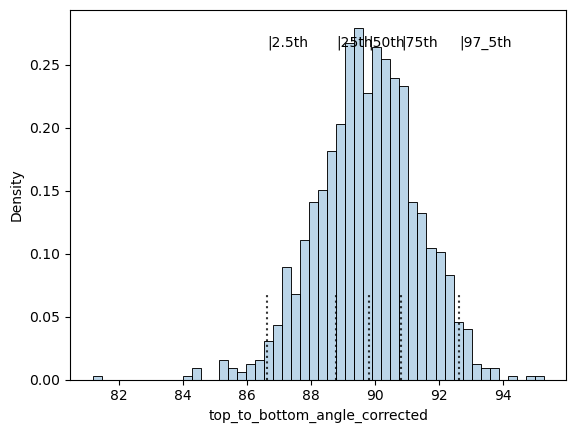

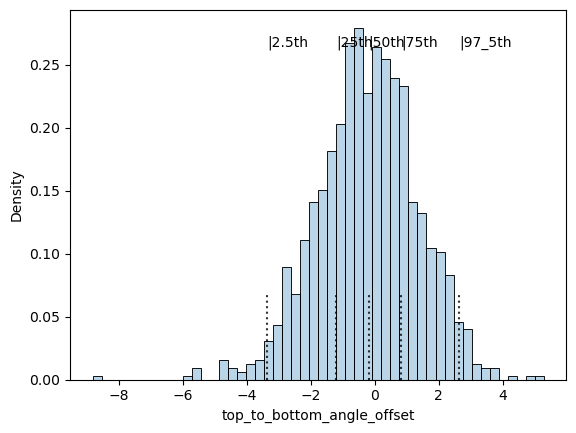

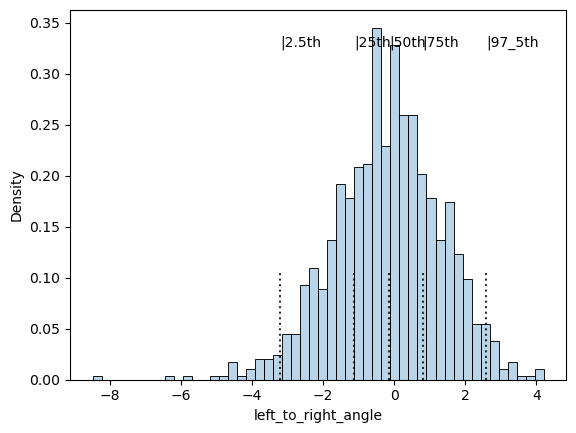

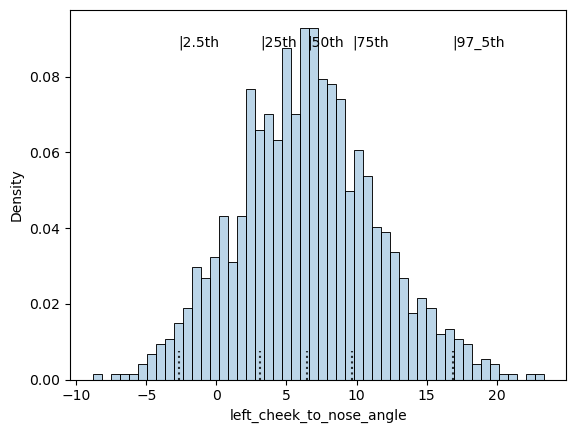

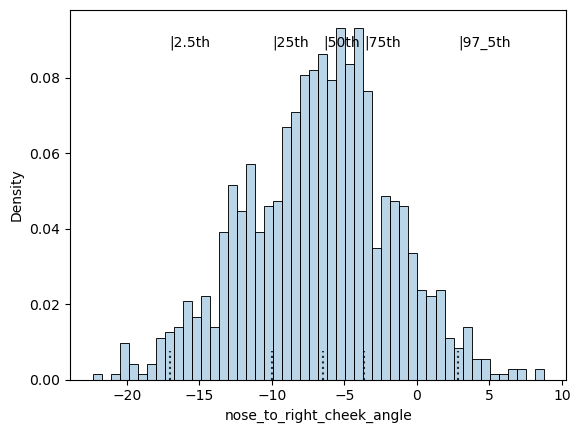

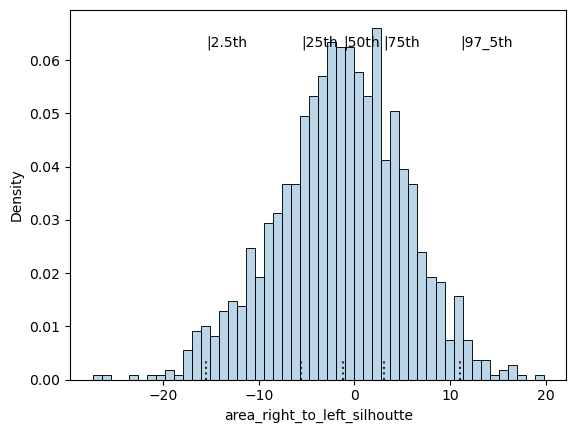

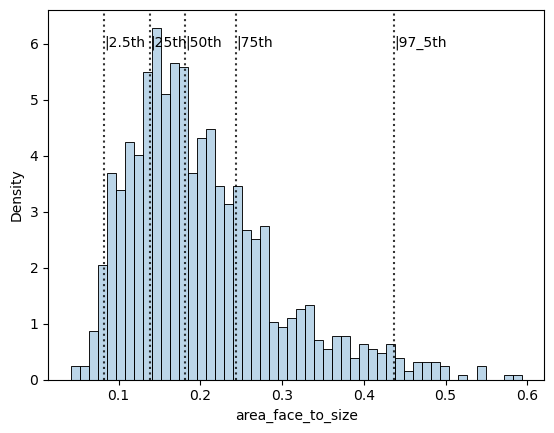

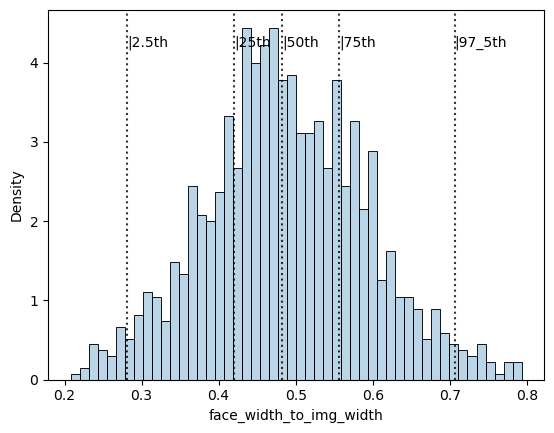

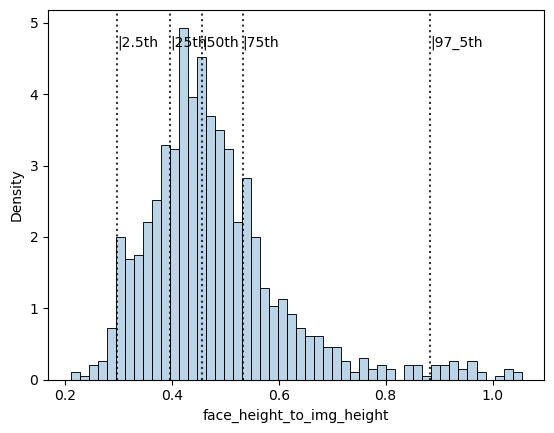

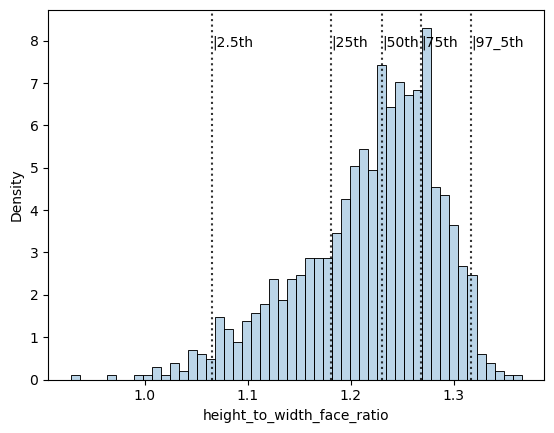

In [17]:
for i in range(len(features_list)):
    plot_and_save_histogram_with_percentiles(df, features_list[i])

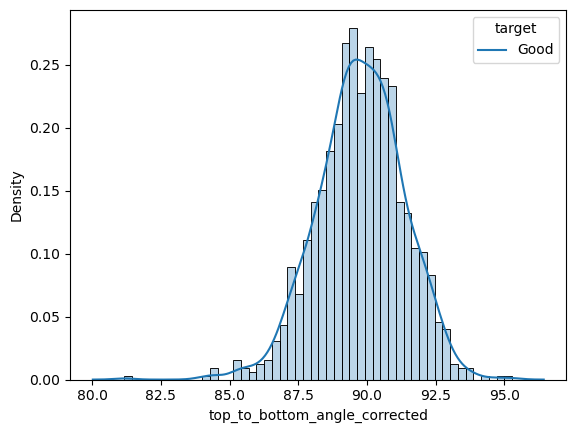

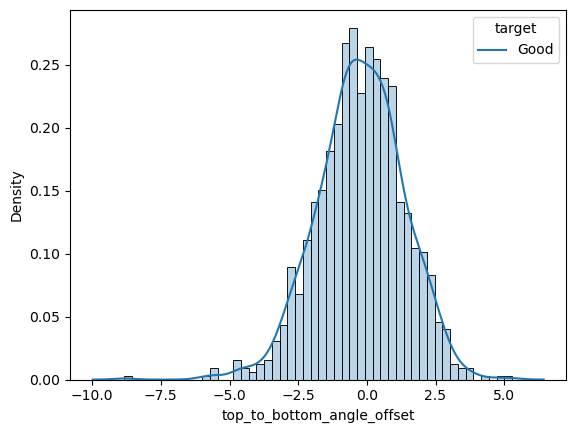

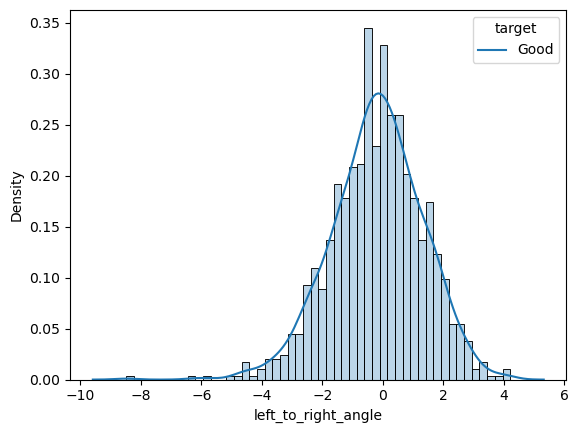

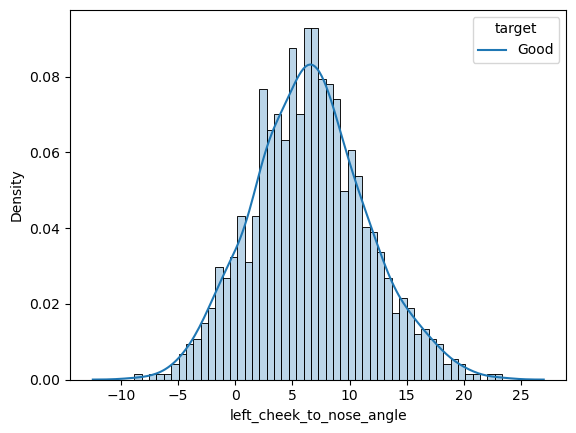

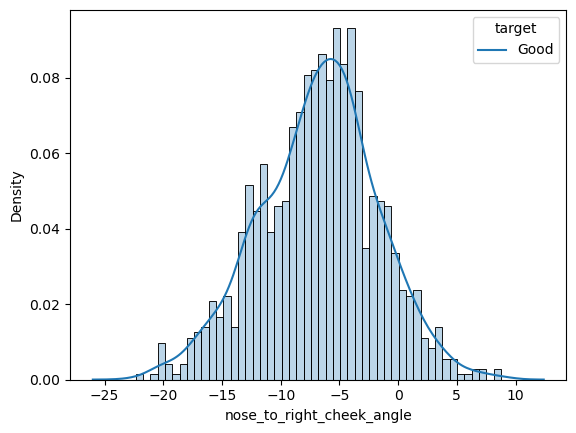

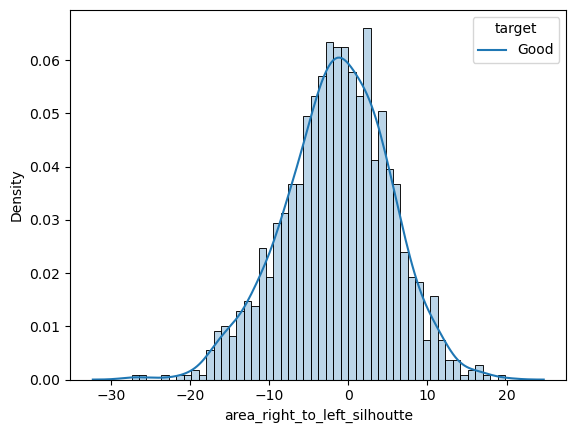

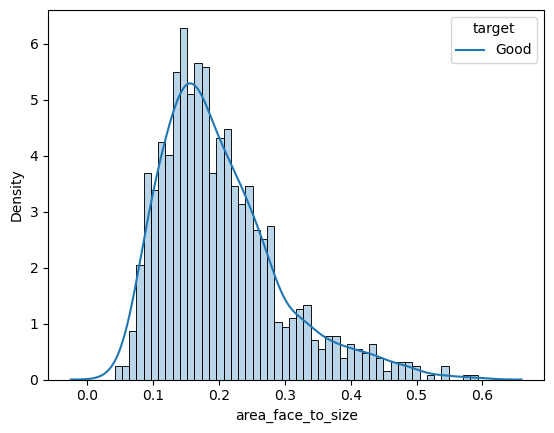

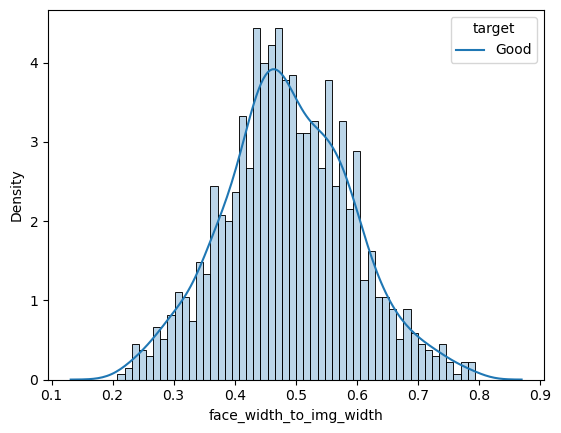

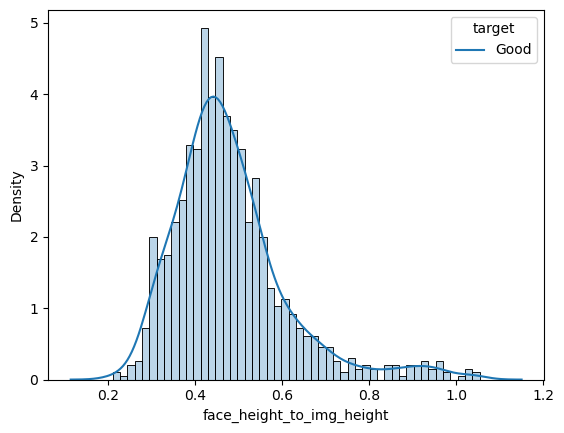

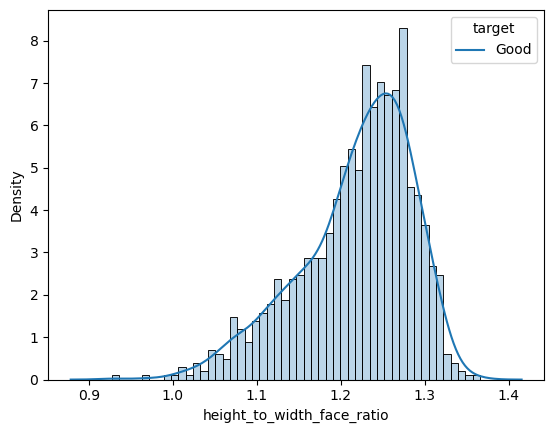

In [18]:
for i in range(len(features_list)):
    plot_and_save_histogram_with_category(df, features_list[i])

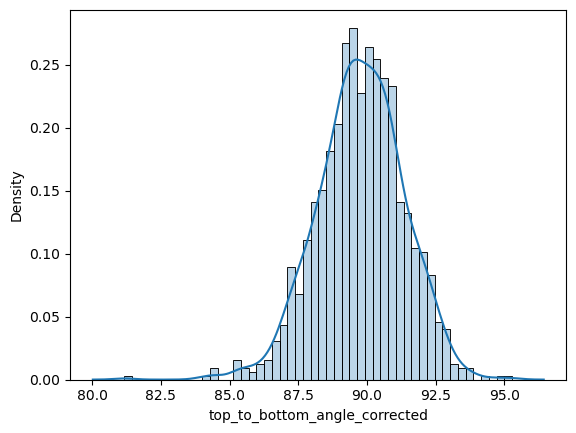

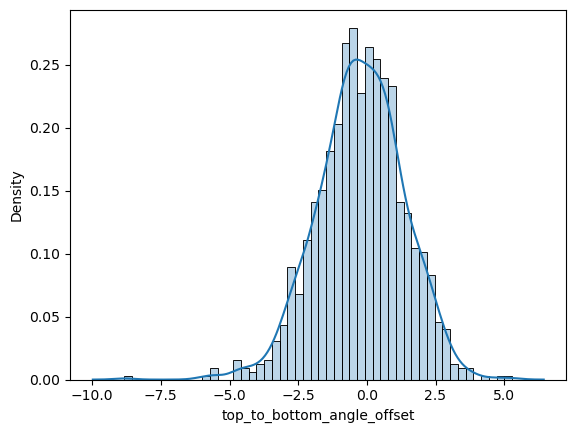

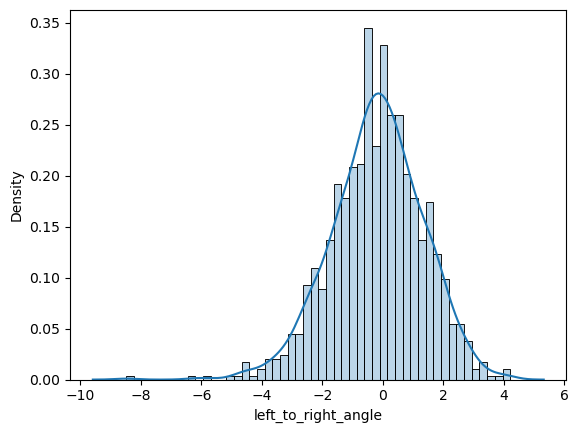

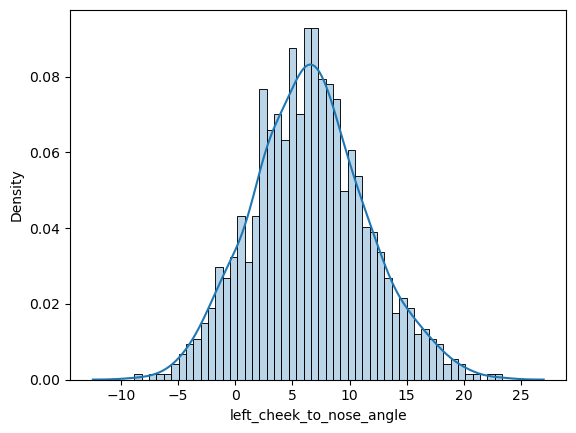

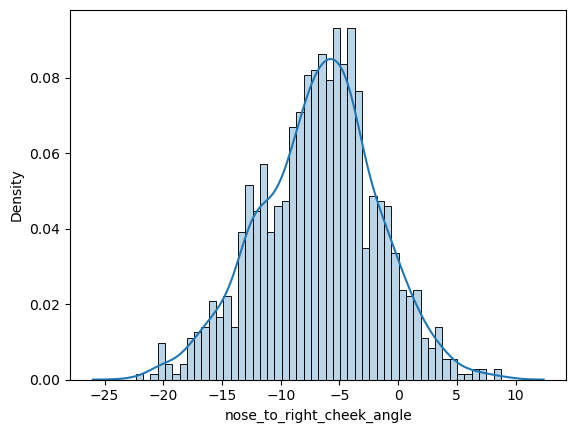

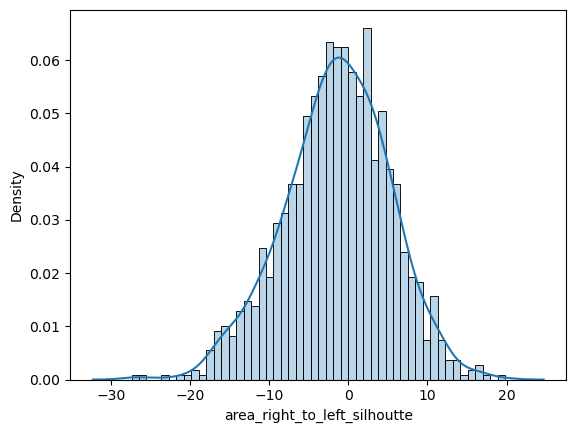

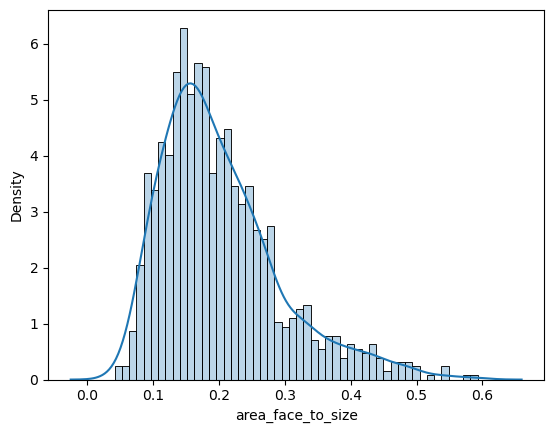

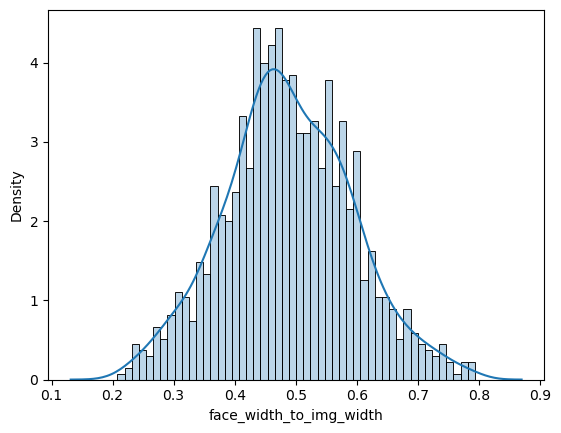

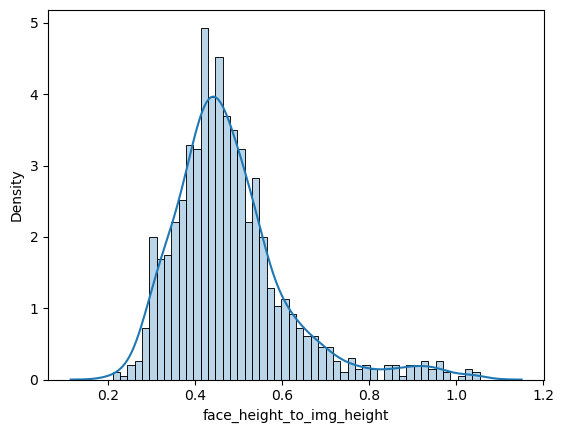

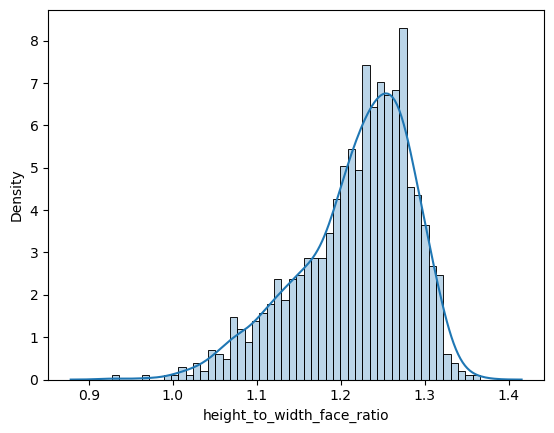

In [19]:
for i in range(len(features_list)):
    plot_and_save_histogram(df, features_list[i])

In [20]:
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

In [21]:
if pairplot == True:
    g = sns.pairplot(df, hue='target',plot_kws=dict(alpha=0.3))
    # # g.map_lower(sns.regplot)
    # g.map_upper(reg_coef)
    plt.savefig('photos/output/plots/pairplot.pdf')

In [22]:
# g = sns.pairplot(df, hue='target',plot_kws=dict(alpha=0.3))
# # # g.map_lower(sns.regplot)
# g.map_upper(reg_coef)
# plt.savefig('photos/output/plots/pairplot_with_coeff.pdf')